In [1]:
import numpy as np
import matplotlib.pyplot as plt

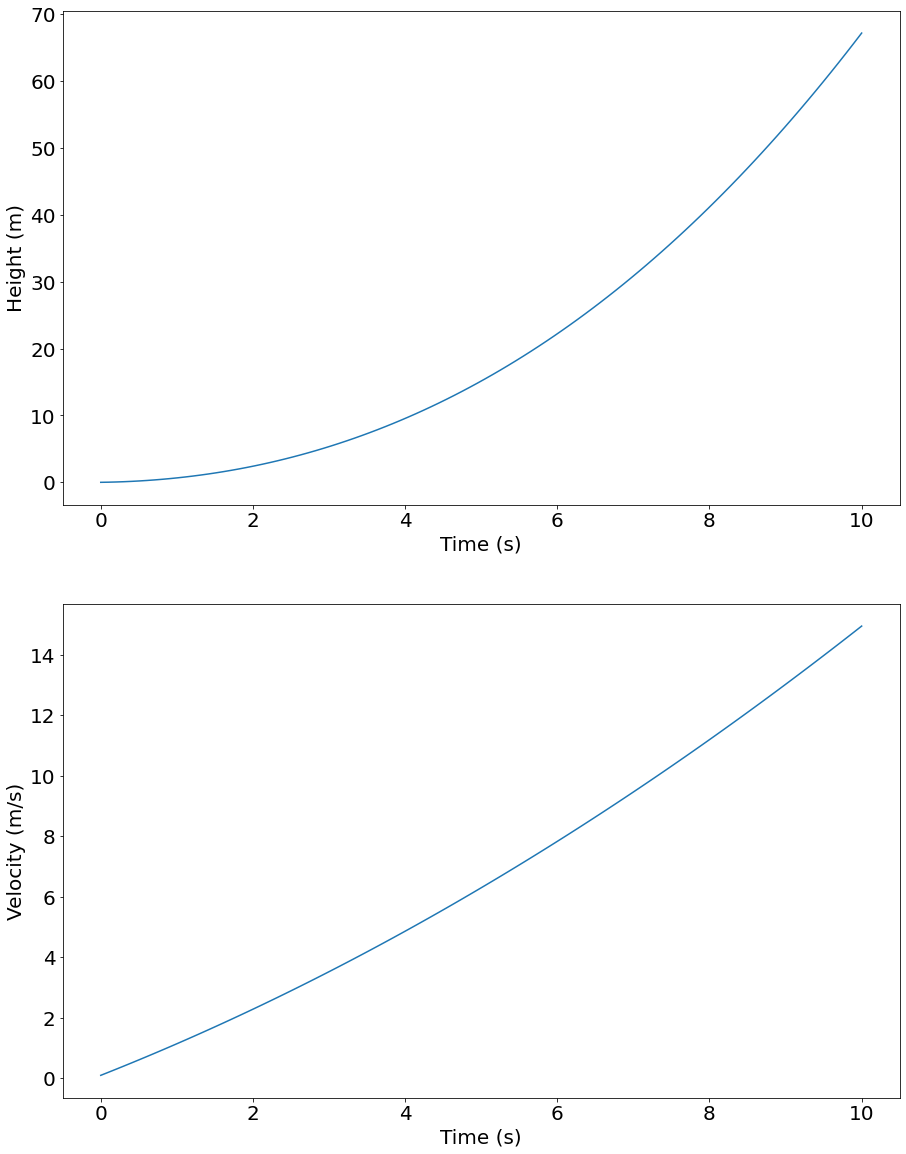

In [2]:
# Define the scenario.

np.random.seed(42)

dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)
true_acceleration = 1 + 0.01 * np.arange(n)  # Linearly increasing acceleration
true_velocity = np.cumsum(true_acceleration * dt)  # Integrate acceleration to get velocity
true_height = np.cumsum(true_velocity * dt)  # Integrate velocity to get height

height_variance = 5
velocity_variance = 1
acceleration_variance = 1

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="Height")
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="Velocity")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

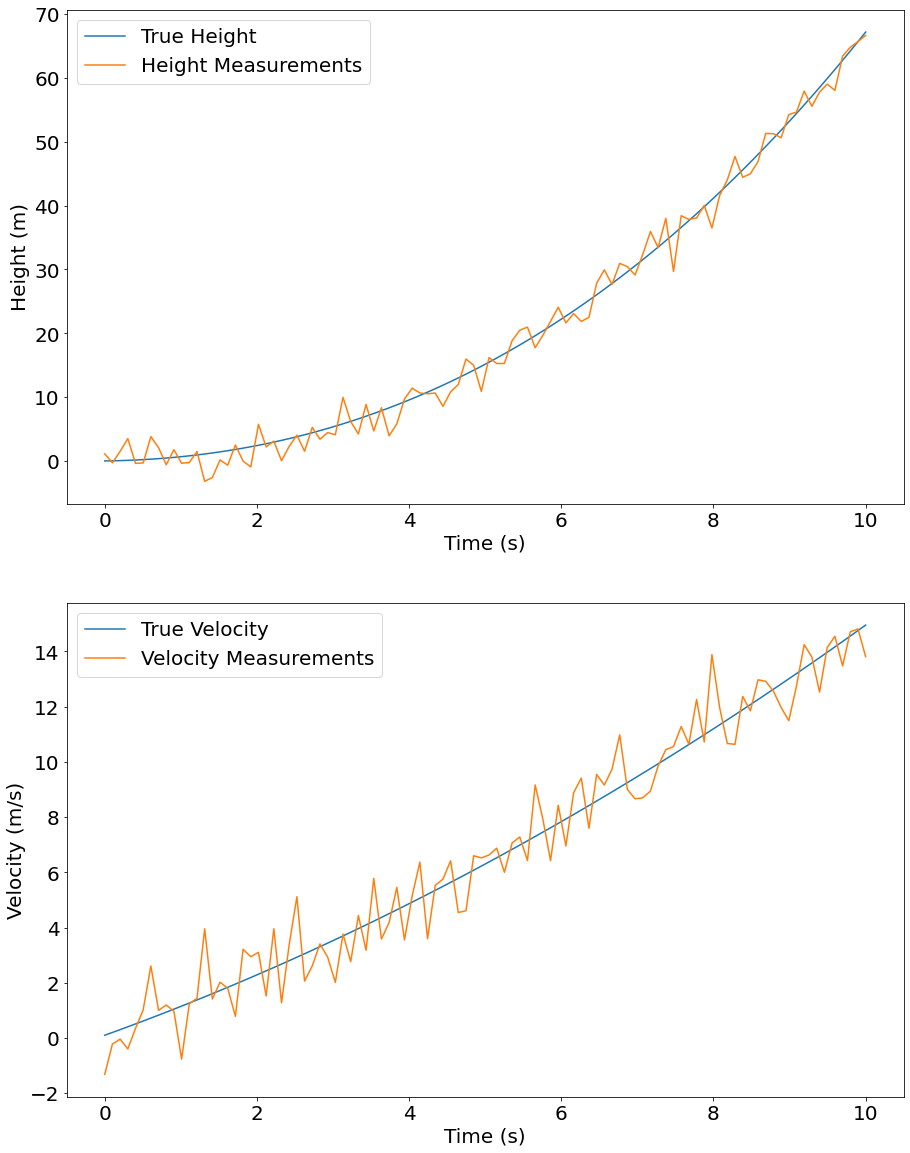

Height Error:
  Sensor only:    2.034 m (RMS)
Velocity Error:
  Sensor only:    0.949 m/s (RMS)


In [3]:
# Sensors only.

height_measurements = true_height + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)
acceleration_measurements = true_acceleration + np.random.normal(0, np.sqrt(acceleration_variance), n)

height_measurement_error = true_height - height_measurements
velocity_measurement_error = true_velocity - velocity_measurements
acceleration_measurement_error = true_acceleration - acceleration_measurements
height_measurement_rms_error = np.sqrt(np.mean(height_measurement_error**2))
velocity_measurement_rms_error = np.sqrt(np.mean(velocity_measurement_error**2))
acceleration_measurement_rms_error = np.sqrt(np.mean(acceleration_measurement_error**2))

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements, label="Height Measurements")
plt.legend()
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Velocity Measurements")
plt.legend()
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

print("Height Error:")
print(f"  Sensor only:    {height_measurement_rms_error:0.3f} m (RMS)")
print("Velocity Error:")
print(f"  Sensor only:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")

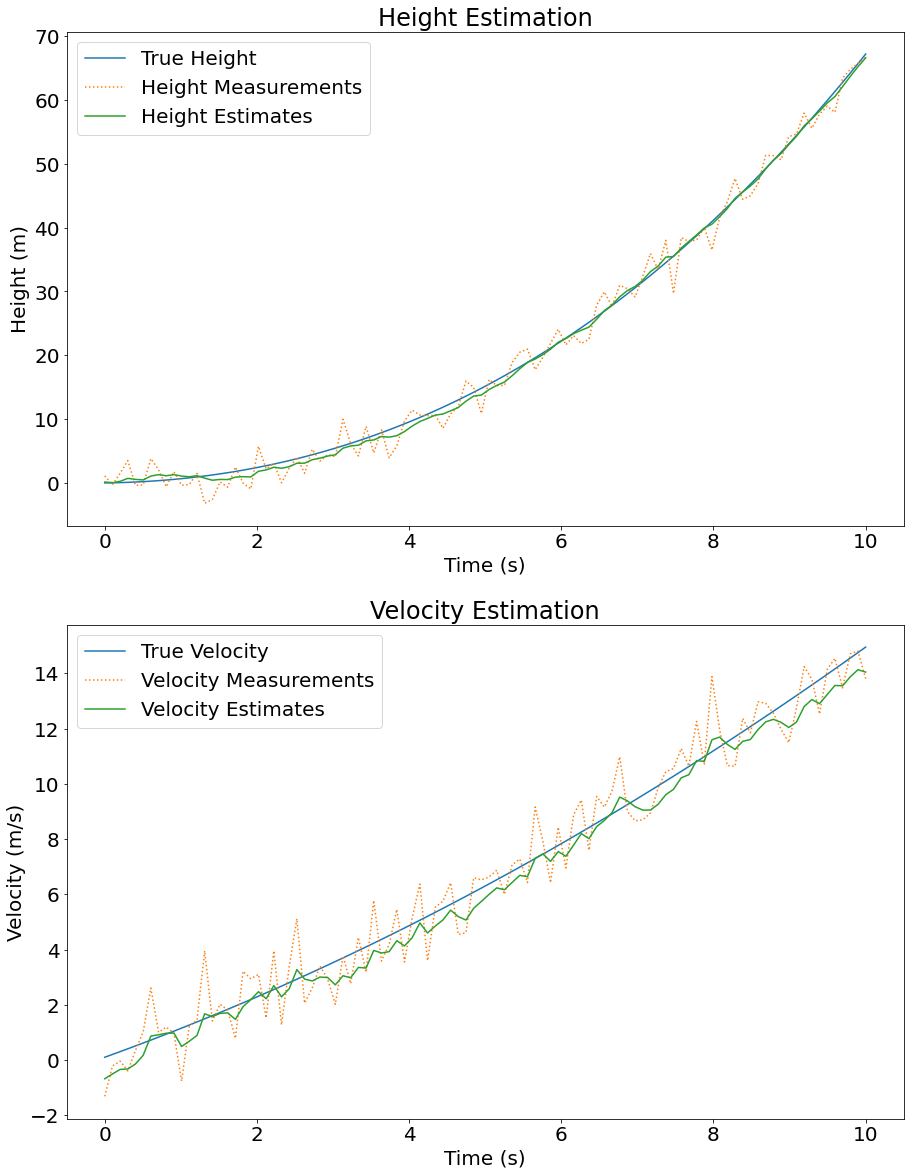

Height Error:
  Sensor only:    2.034 m (RMS)
  Kalman filter:  0.637 m (RMS)
Velocity Error:
  Sensor only:    0.949 m/s (RMS)
  Kalman filter:  0.484 m/s (RMS)


In [9]:
# Kalman filter with height and velocity sensors.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0  ],
              [0,   0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Implement prediction and correction steps.
def prediction_step(x, P, A, Q):
    x = A @ x
    P = A @ P @ A.T + Q
    return x, P

def correction_step(x, P, z, H, R):
    y = z - H @ x
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ y
    P = (np.eye(2) - K @ H) @ P
    return x, P

# Define our initial state and covariance estimates.
x = np.array([[0],
              [0]])
P = np.array([[1, 0],
              [0, 1]])

# Run the simulation and store state estimates in an array.
estimates = np.ndarray((n, 2))
for k in range(n):
    z = np.array([[height_measurements[k]],
                  [velocity_measurements[k]]])
    x, P = prediction_step(x, P, A, Q)
    x, P = correction_step(x, P, z, H, R)
    estimates[k] = x.flatten()

# Calculate errors.
height_estimate_error = true_height - estimates[:, 0]
velocity_estimate_error = true_velocity - estimates[:, 1]
height_estimate_rms_error = np.sqrt(np.mean(height_estimate_error**2))
velocity_estimate_rms_error = np.sqrt(np.mean(velocity_estimate_error**2))

# Plot.
plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.title("Height Estimation")
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements, label="Height Measurements", linestyle="dotted")
plt.plot(t, estimates[:, 0], label="Height Estimates")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.subplot(2, 1, 2)
plt.title("Velocity Estimation")
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Velocity Measurements", linestyle="dotted")
plt.plot(t, estimates[:, 1], label="Velocity Estimates")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

# Print comparison of RMS errors.
print("Height Error:")
print(f"  Sensor only:    {height_measurement_rms_error:0.3f} m (RMS)")
print(f"  Kalman filter:  {height_estimate_rms_error:0.3f} m (RMS)")
print("Velocity Error:")
print(f"  Sensor only:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")
print(f"  Kalman filter:  {velocity_estimate_rms_error:0.3f} m/s (RMS)")

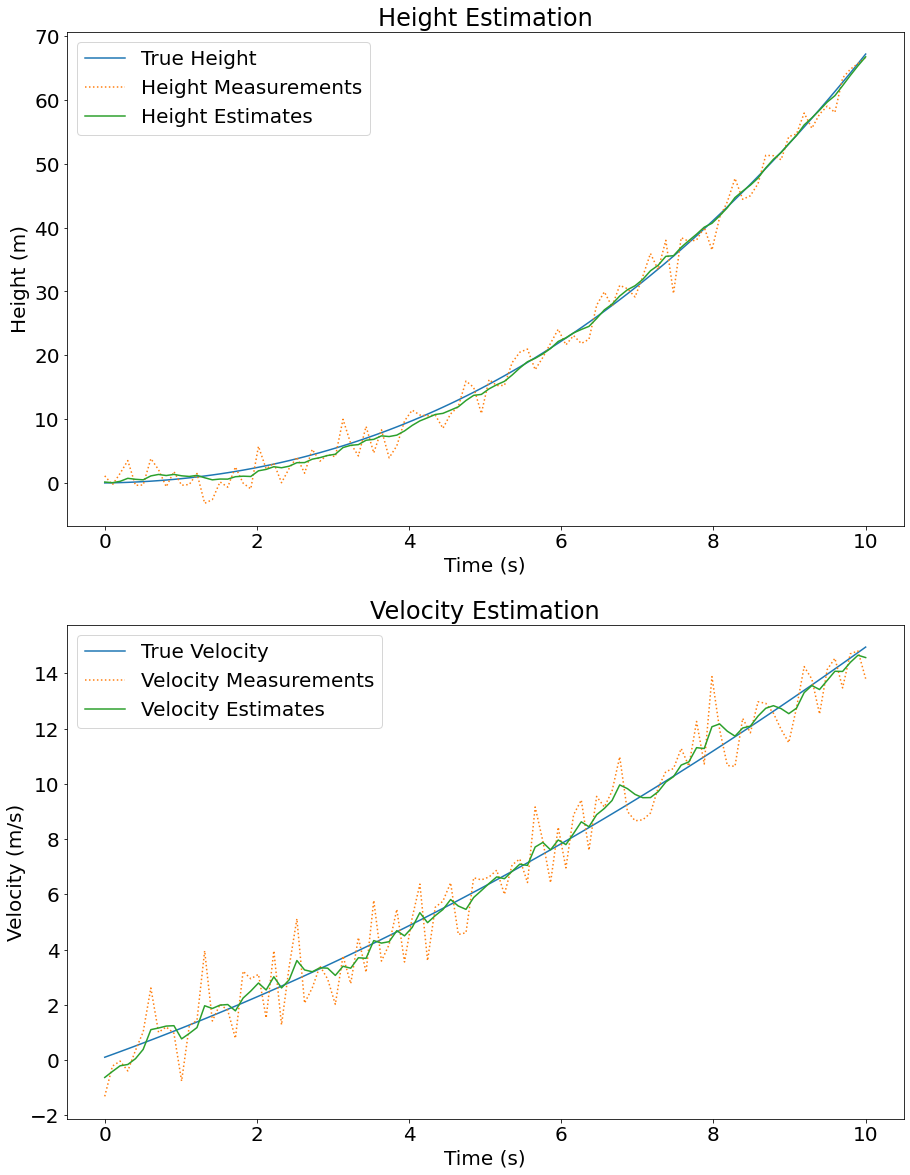

Height Error:
  Sensor only:    2.034 m (RMS)
  Kalman filter:  0.589 m (RMS)
Velocity Error:
  Sensor only:    0.949 m/s (RMS)
  Kalman filter:  0.331 m/s (RMS)


In [7]:
# Kalman filter with control input as well as height and velocity sensors.

# Define our state transition matrix.
A = np.array([[1, dt],
              [0, 1 ]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

# Define our process noise covariance matrix.
Q = np.array([[0.1, 0  ],
              [0,   0.1]])

# Define our observation matrix.
H = np.array([[1, 0],
              [0, 1]])

# Define our measurement noise covariance matrix.
R = np.array([[height_variance, 0                ],
              [0,               velocity_variance]])

# Implement prediction and correction steps.
def prediction_step(x, P, u, A, B, Q):
    x = A @ x + B * u
    P = A @ P @ A.T + Q
    return x, P

def correction_step(x, P, z, H, R):
    y = z - H @ x
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ y
    P = (np.eye(2) - K @ H) @ P
    return x, P

# Define our initial state and covariance estimates.
x = np.array([[0],
              [0]])
P = np.array([[1, 0],
              [0, 1]])

# Run the simulation and store state estimates in an array.
estimates = np.ndarray((n, 2))
for k in range(n):
    u = true_acceleration[k]
    z = np.array([[height_measurements[k]],
                  [velocity_measurements[k]]])
    x, P = prediction_step(x, P, u, A, B, Q)
    x, P = correction_step(x, P, z, H, R)
    estimates[k] = x.flatten()

# Calculate errors.
height_estimate_error = true_height - estimates[:, 0]
velocity_estimate_error = true_velocity - estimates[:, 1]
height_estimate_rms_error = np.sqrt(np.mean(height_estimate_error**2))
velocity_estimate_rms_error = np.sqrt(np.mean(velocity_estimate_error**2))

# Plot.
plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.title("Height Estimation")
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements, label="Height Measurements", linestyle="dotted")
plt.plot(t, estimates[:, 0], label="Height Estimates")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.subplot(2, 1, 2)
plt.title("Velocity Estimation")
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Velocity Measurements", linestyle="dotted")
plt.plot(t, estimates[:, 1], label="Velocity Estimates")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.show()

# Print comparison of RMS errors.
print("Height Error:")
print(f"  Sensor only:    {height_measurement_rms_error:0.3f} m (RMS)")
print(f"  Kalman filter:  {height_estimate_rms_error:0.3f} m (RMS)")
print("Velocity Error:")
print(f"  Sensor only:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")
print(f"  Kalman filter:  {velocity_estimate_rms_error:0.3f} m/s (RMS)")